In [1]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit -*-
# -*- date : 2025-04-24 -*-
# -*- Last revision: 2025-05-02 by janzgraggen -*-
# -*- python version : 3.10.4 -*-
# -*- Description: Notebook that summarizeses the main results-*-

# <center> EE-452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Graph-based EEG Analysis </center>
---

In [5]:
#import libraries
import pandas as pd
from pathlib import Path
import sys

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from seiz_eeg.dataset import EEGDataset

#import modules
import constants
from transform_func import *
from dataloader import load_data
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_path = "../data"

DATA_ROOT = Path(data_path)

clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [11]:
from sklearn.model_selection import train_test_split

labels = clips_tr["label"].values
indices = clips_tr.index.values
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

train = clips_tr.loc[train_indices].sort_index()
val = clips_tr.loc[val_indices].sort_index()

In [13]:
val.to_parquet('val.parquet')

In [14]:
df_val = pd.read_parquet('val.parquet')

In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Shared config
sfreq = 250
n_channels = 19
standard_19_ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
                        'T7', 'C3', 'Cz', 'C4', 'T8',
                        'P7', 'P3', 'Pz', 'P4', 'P8',
                        'O1', 'O2']
info = mne.create_info(ch_names=standard_19_ch_names, sfreq=sfreq, ch_types=['eeg'] * n_channels)
montage = mne.channels.make_standard_montage('standard_1020')

def clean_epoch(epoch_data):
    raw = mne.io.RawArray(epoch_data.T, info, verbose=False)
    raw.set_montage(montage)
    raw.filter(1., 100., verbose=False)
    raw.notch_filter(50., verbose=False)
    raw.set_eeg_reference('average', projection=False, verbose=False)

    ica = ICA(method='infomax', fit_params=dict(extended=True), max_iter='auto', random_state=97)
    ica.fit(raw, verbose=False)

    labels = mne_icalabel.label_components(raw, ica, method='iclabel')
    exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ('eye', 'muscle', 'other')]
    raw_clean = ica.apply(raw.copy(), exclude=exclude_idx, verbose=False)

    return raw_clean.get_data().T  # (samples, channels)

cleaned_data_list = Parallel(n_jobs=-1)(delayed(clean_epoch)(dataset_tr[i][0]) for i in tqdm(range(len(dataset_tr))))

  1%|          | 120/12993 [00:24<44:17,  4.84it/s]

KeyboardInterrupt: 

In [66]:
import mne
from mne.preprocessing import ICA
import mne_icalabel
import numpy as np
from tqdm import tqdm

# Shared config
sfreq = 250
n_channels = 19
standard_19_ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
                        'T7', 'C3', 'Cz', 'C4', 'T8',
                        'P7', 'P3', 'Pz', 'P4', 'P8',
                        'O1', 'O2']
info = mne.create_info(ch_names=standard_19_ch_names, sfreq=sfreq, ch_types=['eeg'] * n_channels)
montage = mne.channels.make_standard_montage('standard_1020')

# Preallocate list for cleaned data
cleaned_data_list = []

for i in tqdm(range(len(dataset_tr))):
    data = dataset_tr[i][0].T  # (channels, samples)

    # Create RawArray and reuse shared info + montage
    raw = mne.io.RawArray(data, info.copy(), verbose=False)
    raw.set_montage(montage)

    # Preprocessing
    raw.filter(1., 100., verbose=False)
    raw.notch_filter(50., verbose=False)
    raw.set_eeg_reference('average', projection=False, verbose=False)

    # ICA: infomax + extended for ICLabel
    ica = ICA(method='infomax', fit_params=dict(extended=True), max_iter='auto', random_state=97)
    ica.fit(raw, verbose=False)

    # ICLabel classification
    labels = mne_icalabel.label_components(raw, ica, method='iclabel')

    # Exclude artifact components
    exclude_idx = [i for i, label in enumerate(labels['labels']) if label in ('eye', 'muscle', 'other')]
    raw_clean = ica.apply(raw.copy(), exclude=exclude_idx, verbose=False)

    # Save cleaned data
    clean_data = raw_clean.get_data().T  # (samples, channels)
    cleaned_data_list.append(clean_data)

  0%|          | 48/12993 [01:24<6:20:18,  1.76s/it]


KeyboardInterrupt: 

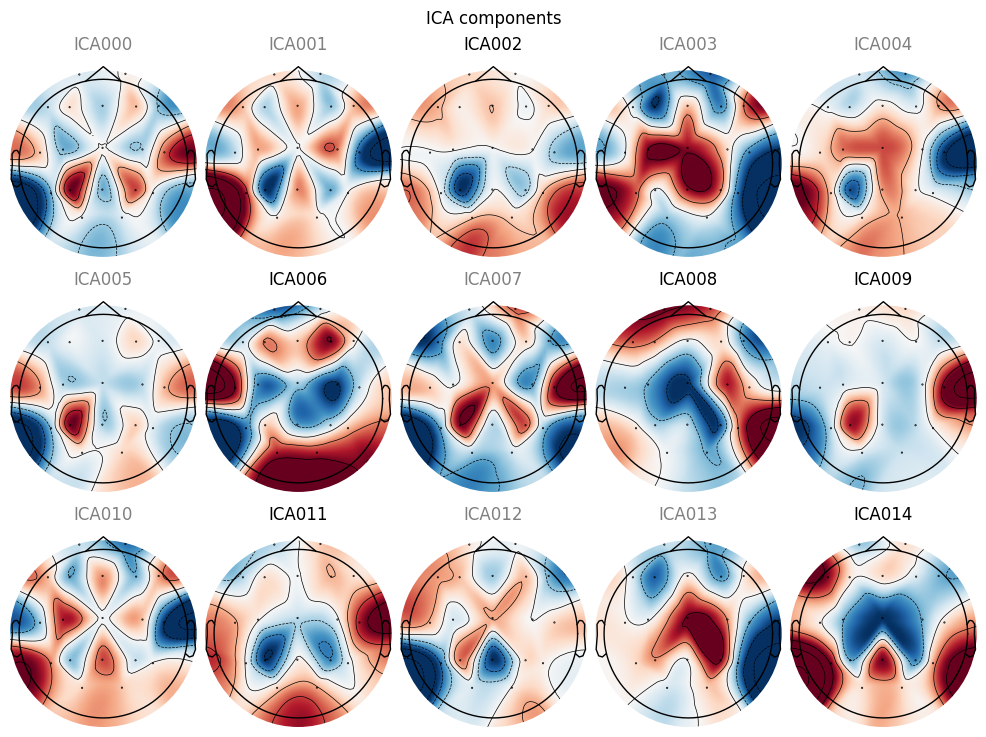

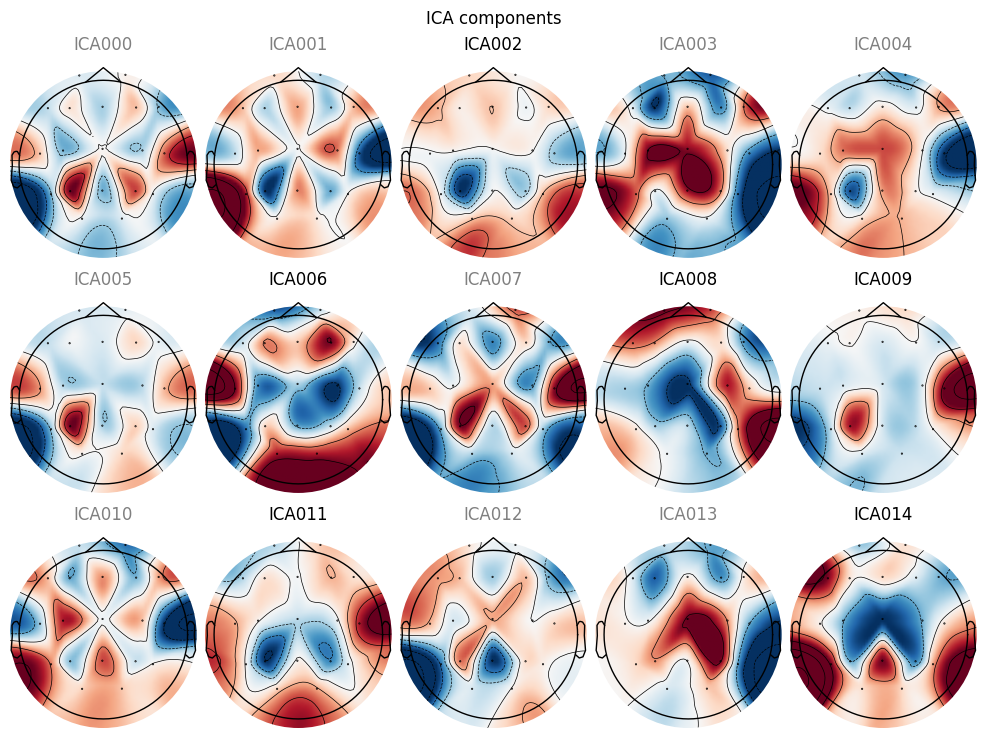

In [62]:
ica.plot_components(inst=raw_clean)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components


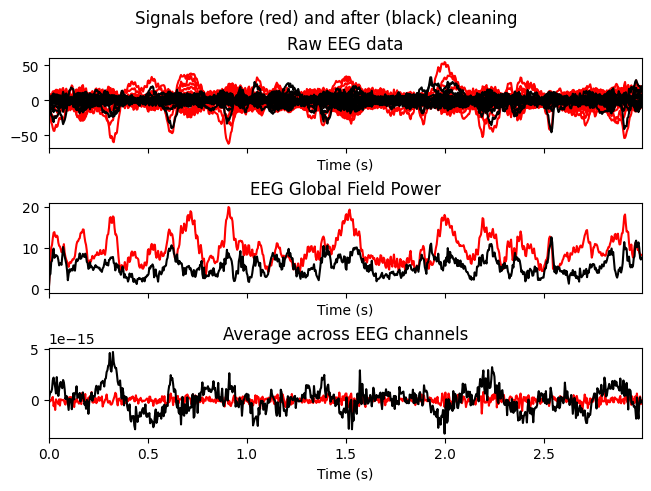

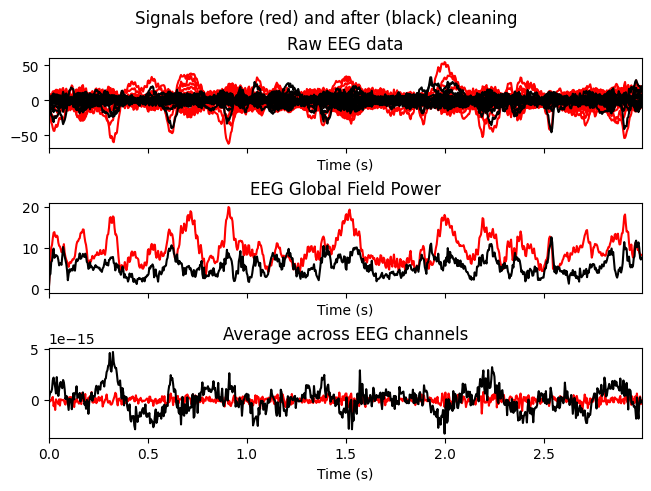

In [63]:
ica.plot_overlay(raw)  # Plots original and cleaned signals